In [1]:
import numpy as np 
from scipy.optimize import fsolve

from viz import *

import matplotlib.pyplot as plt
import seaborn as sns
c = sns.color_palette("Paired")

font_size = 15

red_won = (236/255, 84/255, 74/255)
green_won = (123/255, 192/255, 170/255)

cb = sns.color_palette("colorblind")

ModuleNotFoundError: No module named 'viz'

In [ ]:
# Put this in the libary
def set_plot(ax, x_lim=None, y_lim=None, x_ticks=None, y_ticks=None, x_tick_labels=None, y_tick_labels=None,
        x_label=None, y_label= None, title=None, font_size=None,xrotation=None, spinewidth=2):

    # Make axis pretty by default
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # change all spines
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(spinewidth)
    ax.tick_params(width=spinewidth)

    
    if x_lim is not None:
        ax.set_xlim(x_lim)
    if y_lim is not None:
        ax.set_ylim(y_lim)
    if x_ticks is not None:
        ax.set_xticks(x_ticks)
    if y_ticks is not None:
        ax.set_yticks(y_ticks)
    if x_tick_labels is not None:
        ax.set_xticklabels(x_tick_labels, rotation=xrotation)
    if y_tick_labels is not None:
        ax.set_yticklabels(y_tick_labels)
    if x_label is not None:
        ax.set_xlabel(x_label)
    if y_label is not None:
        ax.set_ylabel(y_label)
    if title is not None:
        ax.set_title(title)
    if font_size is not None:
        set_font_size(ax, font_size)
        
def set_font_size(ax, font_size, legend_font_size=None):
    """Set font_size of all axis text objects to specified value."""
   
    axs = ax
    try:
        iter(axs)
    except TypeError:
        axs = np.array(ax)
    for ax in axs.flatten():
        texts = [ax.title, ax.xaxis.label, ax.yaxis.label] + \
            ax.get_xticklabels() + ax.get_yticklabels()
       
        try:
            texts.extend([ax.zaxis.label] + ax.get_zticklabels())
        except:
            pass

        for text in texts:
            text.set_fontsize(font_size)

        if ax.get_legend():
            if not legend_font_size:
                legend_font_size = font_size
            for text in ax.get_legend().get_texts():
                text.set_fontsize(legend_font_size)
        

In [ ]:
import numpy as np 

def ref_parameters():
    # Parameters 
    vE = 1.0

    # Insulin secretion
    k = 3.4
    C = 2.3
    
    #Ref. insulin
    Imax = 1.0
    I0 = abs(1.0)**k / (abs(1.0)**k + C**k)

    rho = 1.0
    KI_lipo = I0
    LI = 1.0 - rho * (KI_lipo + 1.0) * I0 / (I0 + KI_lipo)
                   
    KA_glut4 = I0 
    SI = 1.0
    
    KIL = 1.0
    KIK = 1.0
    KI_GY = I0
                         
    # Steady state Fluxes see Mathematica
    vGL=0.32805
    vLG=0.165296
    v0=0.165296 
    vL=0.325506
    vG=0.0406883
    vF=0.183097
    vK=0.183097
    vFK=0.0457743
    vA=0.228872 
    vR=0.152581
    
    # Calculate parmeters 
    omega = vGL/SI
    lam = vL
    gamma = vG/SI
    beta = vF
    kappa = vK
    
    alpha = vA/LI
    
    # Resterification
    KF = 0.1
    KG = 0.1
    VR = vR / (1/KF * 1/KG / (1 + 1/KF + 1/KG ))
    
    # Ketogenesis
    KFK = 0.1
    VFK = vFK /(1/(1+KFK))

    # Gluconeogenesis
    KL = 0.1
    VLG = vLG /(1/(1+KL))
    
    # Parameters to manipulate the model
    v_in_I = 0.0 #Insulin infusion
    v_in_L = 0.0 # lactate infusion
    v_in_G = 0.0 # glucose infusion
    v_in_F = 0.0 # fatty-accid infusion
    v_in_K = 0.0 # Ketone infusion   
    
    with_LI = True
    with_SI = True
    with_GI = False
    with_LL = True
    with_LK = True

    return [vE, k, Imax, C, KI_lipo, KA_glut4, KI_GY, KIL, KIK, KF, KG, omega, 
            lam, gamma, beta, kappa, alpha, VR, VFK, KFK, VLG, KL,
            v0, rho, v_in_I, v_in_L, v_in_G, v_in_F, v_in_K, 
            with_LI, with_SI, with_GI, with_LL, with_LK]

parameter_names = ["vE", "k", "Imax", "C", "KI_lipo", "KA_glut4", "KI_GY", "KIL", "KIK", "KF", "KG","omega", 
                   "lam", "gamma", "beta", "kappa", "alpha", "VR", "VFK", "KFK", "VLG", "KL",
                   "v0", "rho", "v_in_I", "v_in_L", "v_in_G", "v_in_F", "v_in_K", 
                   "with_LI", "with_SI", "with_GI", "with_LL", "with_LK"]

# FIXED RATIOS (Energy per molecule rel to glucose)
nG = 1/30
nL = 14/30
nF = 108/30
nK = 22.5/30

TAU_INS = 5*1.3 

In [ ]:
def change_parameters(p,e=[1.0,],ix=["vE",]):
    p_c = p.copy()
    for this_e, this_ix in zip(e,ix):
        i = parameter_names.index(this_ix)
        p_c[i] = this_e
        
    return p_c

In [ ]:
def fluxes(x,A,p):
    L,G,F,K,I = x
    
    vE, k, Imax, C, KI_lipo, KA_glut4, KI_GY, KIL, KIK, KF, KG, omega, \
    lam, gamma, beta, kappa, alpha, VR, VFK, KFK, VLG, KL, \
    v0, rho, v_in_I, v_in_L, v_in_G, v_in_F, v_in_K, \
    with_LI, with_SI, with_GI, with_LL, with_LK = p
    
    # Insulin
    vI = ( Imax * abs(G)**k / (abs(G)**k + C**k) - I) / TAU_INS + v_in_I
    I0 = abs(1.0)**k / (abs(1.0)**k + C**k)

    # Isulin action 
    if with_LI:
        LI = 1.0 - rho * (KI_lipo + 1.0) * I / (I + KI_lipo)
    else:
        LI = 1.0 - rho * (KI_lipo + 1.0) * I0 / (I0 + KI_lipo)
        
    if with_LI:
        SI =  I / (I + KA_glut4) / ( I0 / (I0 + KA_glut4))
    else:
        SI = 1.0
        
    if with_GI:
        GI = (1.0 - (KI_GY + 1.0) * I / (I + KI_GY)) \
             / (1.0 - (KI_GY + 1.0) * I0 / (I0 + KI_GY))
    else:
        GI = 1.0
            
        
    # Lactate action
    if with_LL:
        LL = 1.0/(L/KIL+1.0) * (1.0/KIL+1.0)
    else:
        LL = 1.0
        
    # Ketone action
    if with_LK:
        LK = 1.0/(K/KIK+1.0) * 2.0
    else:
        LK = 1.0

    M = vE/(nG*omega*G*SI + nL*lam*L + gamma*G*SI + nF*beta*F + nK*kappa*K)
        
    vGL = omega*G*SI*M
    vG = gamma*G*SI*M
    vL = lam*L*M
    vF = beta*F*M
    vK = kappa*K*M
    
    vA = alpha*A * LI * LL * LK 
    vR = VR * (G/KG * F/KF)/ (1 + G/KG + F/KF)
    
    vFK = VFK * F/(F+KFK)
    vLG = VLG * L/(L+KL)
    
    v0 = v0 * GI
    vLG = vLG * GI
    
    return np.array([vL, vG, vF, vK, vGL, vFK,  vLG, v0, vA, vR,
            v_in_L, v_in_G, v_in_F, v_in_K, vI])
    

def equation(x,A,p):
    vL, vG, vF, vK, vGL, vFK, vLG, v0, vA, vR, \
    v_in_L, v_in_G, v_in_F, v_in_K, vI = fluxes(x,A,p) 

    dLdt = 2.0*vGL - 2.0*vLG - vL + v_in_L
    dGdt = v0 + 1/2*(vA -vR) + vLG - vGL - vG + v_in_G
    dFdt = 3.0*(vA-vR) - vF - vFK + v_in_F
    dKdt = 4.0*vFK - vK + v_in_K
    dIdt = vI
    
    # Scale the dynamic equation to relative to glucose 
    # concentration

    return [dLdt*5, dGdt, dFdt*10, dKdt*5, dIdt]
    
def steady_state(A,p, x0=[1.0,1.0,1.0,1.0,0.035]):
    return fsolve(equation,x0,args=(A,p))


In [ ]:
p = ref_parameters()
steady_state(1.0,p)


array([1.00000155, 0.99999932, 1.00000359, 1.0000023 , 0.05562486])

In [ ]:

# N = 101
# X = np.ones((N,5))
# S = np.linspace(0,5,N)
# X[:,3] = S
# burning_ref = np.stack([fluxes(x, 1.0, p)[:4] * energy_scaling for x in X])



# f, ax = plt.subplots(1,1, figsize=(5,4))

# ax.fill_between(S, burning_ref[:,0], color=c[4])
# ax.fill_between(S, burning_ref[:,0], burning_ref[:,0]+burning_ref[:,1], color=c[5])
# ax.fill_between(S, burning_ref[:,0]+burning_ref[:,1], burning_ref[:,0]+burning_ref[:,1]+burning_ref[:,2], color=c[6])
# ax.fill_between(S, burning_ref[:,0]+burning_ref[:,1]+burning_ref[:,2], 
#                 burning_ref[:,0]+burning_ref[:,1]+burning_ref[:,2]+burning_ref[:,3], color=c[2])


# set_plot(ax, font_size=16)

In [ ]:
# Stacked bar plot 
energy_scaling = np.array([nL,1.0, nF,nK,nG])

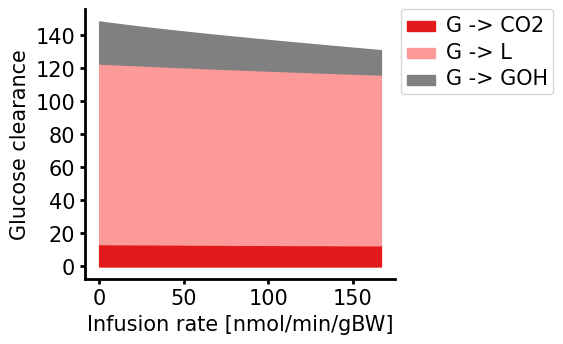

In [ ]:
# Pertubaive keteones
fig, ax = plt.subplots(1,1,figsize=(4,3.5))

# Perturbative ketones 
v_ket = np.linspace(0,0.5)
scaling = 2000/6 # 2000 O2 nmol/min/gBW 6 O2 per glucose
# Feedback
X_0 = np.array([perturbative_infusion_steady_state(v_in_K=v) for v in v_ket])
F_0 = np.array([perturbative_infusion_fluxes(v_in_K=v) * scaling for v in v_ket])


ax.fill_between(v_ket*scaling,F_0[:,1],color=c[5])
ax.fill_between(v_ket*scaling,F_0[:,1],F_0[:,1]+F_0[:,4],color=c[4])
ax.fill_between(v_ket*scaling,F_0[:,1]+F_0[:,4], F_0[:,1]+F_0[:,4]+0.5*F_0[:,9],color="grey")

#ax[1].fill_between(v_ket*scaling,F_0[:,0],color=c[4])

labels = ["G -> CO2", "G -> L",  "G -> GOH", ]
plt.legend(labels, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)


set_plot(ax, 
         x_label="Infusion rate [nmol/min/gBW]",
         y_label="Glucose clearance",
        font_size=font_size )





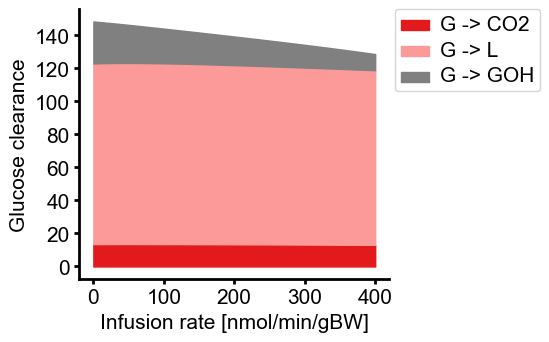

In [ ]:
# Perturbative Lactate 
fig, ax = plt.subplots(1,1,figsize=(4,3.5))

v_lac = np.linspace(0,1.2)
scaling = 2000/6 # 2000 O2 nmol/min/gBW 6 O2 per glucose
# Feedback
X_0 = np.array([perturbative_infusion_steady_state(v_in_L=v) for v in v_lac])
F_0 = np.array([perturbative_infusion_fluxes(v_in_L=v)*scaling for v in v_lac])


ax.fill_between(v_lac*scaling,F_0[:,1],color=c[5])
ax.fill_between(v_lac*scaling,F_0[:,1],F_0[:,1]+F_0[:,4],color=c[4])
ax.fill_between(v_lac*scaling,F_0[:,1]+F_0[:,4], F_0[:,1]+F_0[:,4]+0.5*F_0[:,9],color="grey")

#ax[1].fill_between(v_ket*scaling,F_0[:,0],color=c[4])

labels = ["G -> CO2", "G -> L",  "G -> GOH", ]
plt.legend(labels, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)


set_plot(ax, 
         x_label="Infusion rate [nmol/min/gBW]",
         y_label="Glucose clearance",
         font_size=font_size )



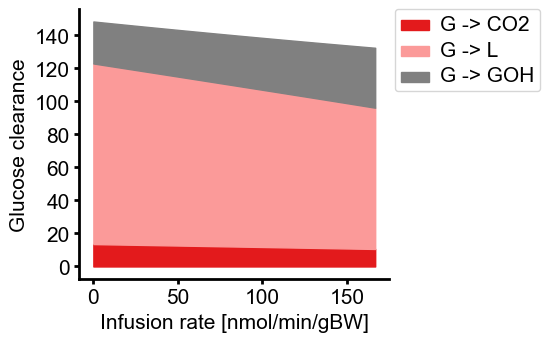

In [ ]:
# Perturbative Fatty acids 
fig, ax = plt.subplots(1,1,figsize=(4,3.5))

v_ffa = np.linspace(0,0.5)
scaling = 2000/6 # 2000 O2 nmol/min/gBW 6 O2 per glucose
# Feedback
X_0 = np.array([perturbative_infusion_steady_state(v_in_F=v) for v in v_ffa])
F_0 = np.array([perturbative_infusion_fluxes(v_in_F=v)*scaling for v in v_ffa])

ax.fill_between(v_ffa*scaling,F_0[:,1],color=c[5])
ax.fill_between(v_ffa*scaling,F_0[:,1],F_0[:,1]+F_0[:,4],color=c[4])
ax.fill_between(v_ffa*scaling,F_0[:,1]+F_0[:,4], F_0[:,1]+F_0[:,4]+0.5*F_0[:,9],color="grey")

#ax[1].fill_between(v_ket*scaling,F_0[:,0],color=c[4])

labels = ["G -> CO2", "G -> L",  "G -> GOH", ]
plt.legend(labels, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)


set_plot(ax, 
         x_label="Infusion rate [nmol/min/gBW]",
         y_label="Glucose clearance",
         font_size=font_size )

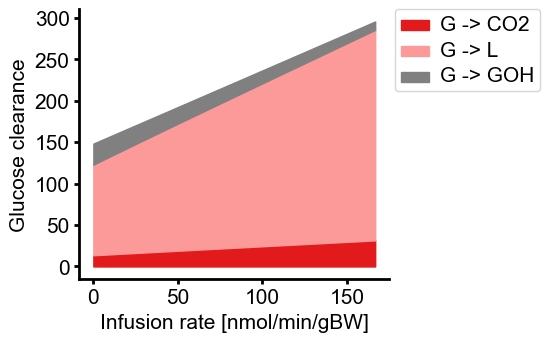

In [ ]:
# Perturbative Fatty acids 
fig, ax = plt.subplots(1,1,figsize=(4,3.5))

v_glu = np.linspace(0,0.5)
scaling = 2000/6 # 2000 O2 nmol/min/gBW 6 O2 per glucose
# Feedback
X_0 = np.array([perturbative_infusion_steady_state(v_in_G=v) for v in v_glu])
F_0 = np.array([perturbative_infusion_fluxes(v_in_G=v)*scaling for v in v_glu])

ax.fill_between(v_glu*scaling,F_0[:,1],color=c[5])
ax.fill_between(v_glu*scaling,F_0[:,1],F_0[:,1]+F_0[:,4],color=c[4])
ax.fill_between(v_glu*scaling,F_0[:,1]+F_0[:,4], F_0[:,1]+F_0[:,4]+0.5*F_0[:,9],color="grey")

#ax[1].fill_between(v_ket*scaling,F_0[:,0],color=c[4])

labels = ["G -> CO2", "G -> L",  "G -> GOH", ]
plt.legend(labels, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)


set_plot(ax, 
         x_label="Infusion rate [nmol/min/gBW]",
         y_label="Glucose clearance",
         font_size=font_size )

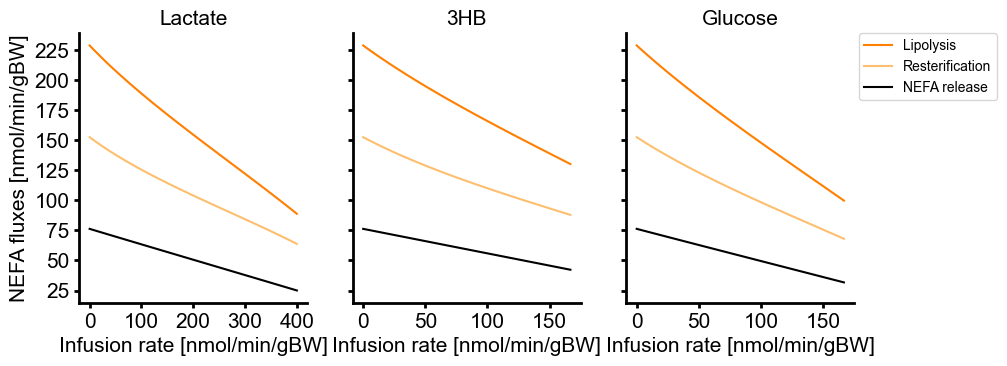

In [ ]:
# Figure 2 

# Adipose fatty-acid release Perturbative infusion  
fig, ax = plt.subplots(1,3,figsize=(10,3.5),sharey='row')
ffa_scaling = 2000/6

# Feedback
F_0 = np.array([perturbative_infusion_fluxes(v_in_L=v)[8:10] for v in v_lac])
ax[0].plot(v_lac*scaling, F_0[:,0]*3*ffa_scaling, color=c[7])
ax[0].plot(v_lac*scaling, F_0[:,1]*3*ffa_scaling, color=c[6])
ax[0].plot(v_lac*scaling, (F_0[:,0]-F_0[:,1])*3*ffa_scaling, color='black')

set_plot(ax[0], 
         x_label="Infusion rate [nmol/min/gBW]",
         y_label="NEFA fluxes [nmol/min/gBW]",
         font_size=font_size,
         title="Lactate"
         #y_lim = [0,1.0]
        )


F_0 = np.array([perturbative_infusion_fluxes(v_in_K=v)[8:10] for v in v_ket])
ax[1].plot(v_ket*scaling, F_0[:,0]*3*ffa_scaling, color=c[7])
ax[1].plot(v_ket*scaling,  F_0[:,1]*3*ffa_scaling, color=c[6])
ax[1].plot(v_ket*scaling, (F_0[:,0]-F_0[:,1])*3*ffa_scaling, color='black')

set_plot(ax[1], 
         x_label="Infusion rate [nmol/min/gBW]",
         font_size=font_size,
         title="3HB"
         #y_lim = [0,1.0]
        )

F_0 = np.array([perturbative_infusion_fluxes(v_in_G=v)[8:10] for v in v_glu])
ax[2].plot(v_glu*scaling, F_0[:,0]*3*ffa_scaling, color=c[7])
ax[2].plot(v_glu*scaling, F_0[:,1]*3*ffa_scaling, color=c[6])
ax[2].plot(v_glu*scaling, (F_0[:,0]-F_0[:,1])*3*ffa_scaling, color='black')

set_plot(ax[2], 
         x_label="Infusion rate [nmol/min/gBW]",
         font_size=font_size,
         title="Glucose"
         #y_lim = [0,1.0]
        )


labels = ["Lipolysis", "Resterification", "NEFA release"]
plt.legend(labels, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.show()

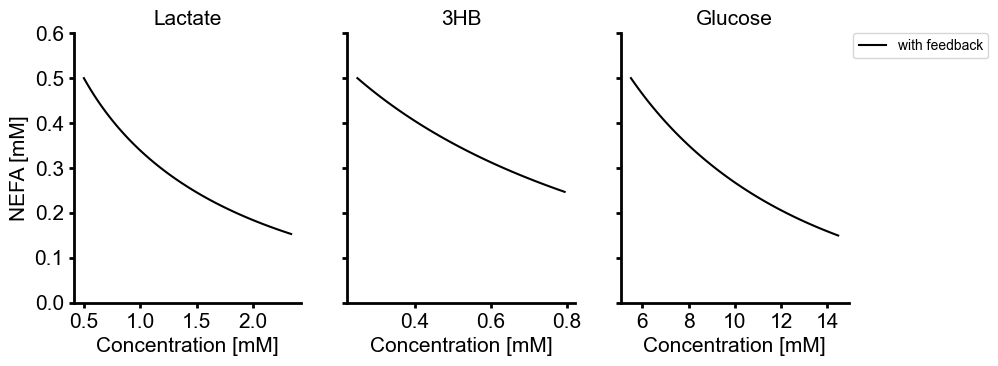

In [ ]:
# Figure 2 

# Adipose fatty-acid release Perturbative infusion  
fig, ax = plt.subplots(1,3,figsize=(10,3.5),sharey='row')
ffa_scaling = 2000/6

# Feedback
X_0 = np.array([perturbative_infusion_steady_state(v_in_L=v) for v in v_lac])
ax[0].plot(X_0[:,0] * 0.5, X_0[:,2] * 0.5, color='black')

#with_LL, with_LK 
X_0 = np.array([perturbative_infusion_steady_state(v_in_L=v, with_LL=False) for v in v_lac])
#ax[0].plot(X_0[:,0] * 0.5, X_0[:,2] * 0.5, color='black',linestyle='dashed')

set_plot(ax[0], 
         x_label="Concentration [mM]",
         y_label="NEFA [mM]",
         font_size=font_size,
         title="Lactate"
         #y_lim = [0,1.0]
        )


# Feedback
X_0 = np.array([perturbative_infusion_steady_state(v_in_K=v) for v in v_ket])
ax[1].plot(X_0[:,3] * 0.25, X_0[:,2] * 0.5, color='black')

#with_LL, with_LK 
X_0 = np.array([perturbative_infusion_steady_state(v_in_K=v, with_LK=False) for v in v_ket])
#ax[1].plot(X_0[:,3] * 0.25, X_0[:,2] * 0.5, color='black',linestyle='dashed')

set_plot(ax[1], 
         x_label="Concentration [mM]",
         font_size=font_size,
         title="3HB"
         #y_lim = [0,1.0]
        )

X_0 = np.array([perturbative_infusion_steady_state(v_in_G=v) for v in v_glu])
ax[2].plot(X_0[:,0] * 5.5, X_0[:,2] * 0.5, color='black')

X_0 = np.array([perturbative_infusion_steady_state(v_in_G=v, rho=0) for v in v_glu])
#ax[2].plot(X_0[:,0] * 5.5, X_0[:,2] * 0.5, color='black',linestyle='dashed')

set_plot(ax[2], 
         x_label="Concentration [mM]",
         font_size=font_size,
         title="Glucose",
         y_lim = [0,0.6]
        )

labels = ["with feedback", "missing feedback",]

plt.legend(labels, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

In [ ]:
import pandas as pd 
df_won = pd.read_csv("./../../paper/data/wons_glamp_data_GIR.csv")
df_won_melt = df_won.melt(id_vars=["Time","Condtion"]).dropna()

df_won_melt.head()

,Time,Condtion,variable,value
0,0,1.25 mU Insulin,Sample 1,0.00
1,10,1.25 mU Insulin,Sample 1,21.62
2,20,1.25 mU Insulin,Sample 1,21.62
3,30,1.25 mU Insulin,Sample 1,25.22
4,40,1.25 mU Insulin,Sample 1,28.83


In [ ]:
# Simulate perturbative simulations
def insulin_clamp_dynamic(insulin_level,time,A,**kwargs):

    # Unpack parameters 
    if kwargs == {}:
        p = ref_parameters()
    else:
        (keys,values) = zip(*kwargs.items())
        p = change_parameters(ref_parameters(), values, ix=keys)
      
    # Get steady state from parameter perturbation
    X0 = steady_state(A,p)

    euglycemic_clamp = lambda x,t,A,p,: equation(x,A,p) * np.array([1,0,1,1,1])
    
    # Glucose infusion rate == dGdt 
    GIR = lambda x,A,p: -equation(x,A,p)[1]

    p_ins = change_parameters(p, [insulin_level,], ['v_in_I'])
    sol_X = odeint(euglycemic_clamp, X0, time, args=(A,p_ins,))
    
    sol_GIR = np.array([GIR(x,A,p) for x in sol_X])

    return sol_X, sol_GIR


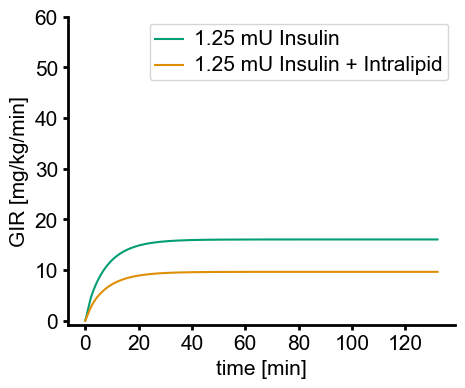

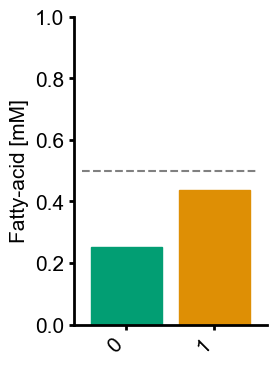

In [ ]:
# Dose dependence insulin 
from scipy.integrate import odeint
import seaborn as sns 


I0 = 0.034
# Figure 1 C/D  Insulin clamps
vI1 = 0.034/TAU_INS # Double basal fasted insulin levles
vI2 = 0.034*3/TAU_INS # Four times basal fasted insulin levles

# Intralipid
vF = 0.3

# Glucose infusion rate over time
A = 1.0
euglycemic_clamp = lambda x,t,A,p,: equation(x,A,p) * np.array([1,0,1,1,1])
# VE 
scaling = 2000/6*180/1000 # 2000 nmol/min/g O2 , 6O2 / GLucose
# Time scaling 
t_scaling = 80*5.5/333
t = np.linspace(0,100,500)


# Simulate clamps
sol1,GIR1 = insulin_clamp_dynamic(0.034/TAU_INS,t,1.0,)
sol2,GIR2 = insulin_clamp_dynamic(0.034/TAU_INS,t,1.0,v_in_F=vF)


fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111)

plt.plot(t*t_scaling, GIR1 * scaling, color=cb[2])
plt.plot(t*t_scaling ,GIR2 * scaling, color=cb[1])
 
lables = ["1.25 mU Insulin","1.25 mU Insulin + Intralipid",]
plt.legend(lables,loc='upper right',)


# TODO scale this 
set_plot(ax,
         y_label='GIR [mg/kg/min]', 
         x_label='time [min]',
         y_ticks=np.linspace(0,60,7),
         x_ticks=np.linspace(0,120,7),
         font_size=font_size)


plt.savefig('dose_dep_clamp_glucose_infusion_rate.png')
plt.savefig('dose_dep_clamp_glucose_infusion_rate.svg')


fig = plt.figure( figsize=(2.5,4))
ax = fig.add_subplot(111)

barlist = plt.bar([0,1],[sol1[-1,2]*0.5 , sol2[-1,2]*0.5,]) #sol3[-1,2]*0.5, sol4[-1,2]*0.5], )
plt.plot([-0.5,1.5],[0.5, 0.5], '--', color='grey')
barlist[0].set_color(cb[2])
barlist[1].set_color(cb[1])
# barlist[2].set_color(cb[0])
# barlist[3].set_color(cb[3])

plt.xticks(rotation=45, ha='right')

# TODO scale this 
set_plot(ax,
         y_label='Fatty-acid [mM]', 
         y_lim = [0,1],
         #y_ticks=np.linspace(0,0.5,3),
         #x_ticks=np.linspace(0,25,6),
         font_size=font_size)

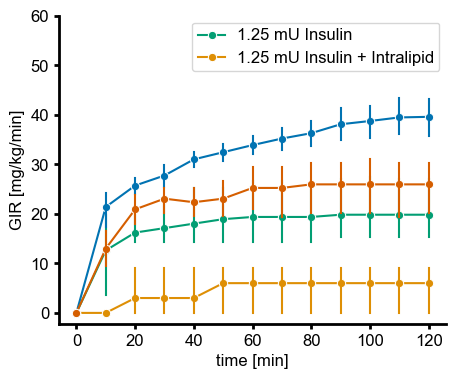

In [ ]:



fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111)

#Plot the real data from WON
sns.lineplot(data=df_won_melt, err_style="bars",
            x="Time", y="value", hue="Condtion",
             marker='o', palette=[cb[2], cb[1], cb[0], cb[3] ] 
            )


#plt.legend(lables, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.legend(lables,loc='upper right',)

# TODO scale this 
set_plot(ax,
         y_label='GIR [mg/kg/min]', 
         x_label='time [min]',
         y_ticks=np.linspace(0,60,7),
         x_ticks=np.linspace(0,120,7),
         font_size=12)


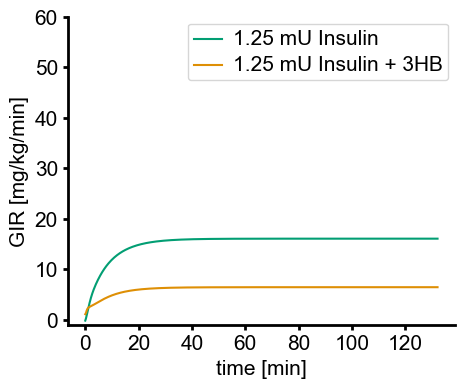

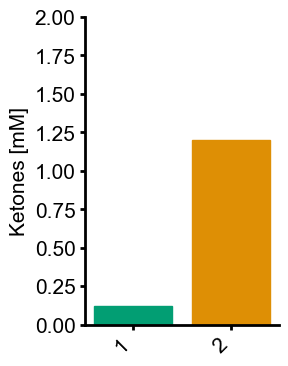

In [ ]:
# Dose dependence insulin 
from scipy.integrate import odeint
import seaborn as sns 


I0 = 0.034
# Figure 1 C/D  Insulin clamps
vI1 = 0.034/TAU_INS # Double basal fasted insulin levles
vI2 = 0.034*3/TAU_INS # Four times basal fasted insulin levles

# Ketone infusion
vK = 0.8

# Glucose infusion rate over time
A = 1.0
euglycemic_clamp = lambda x,t,A,p,: equation(x,A,p) * np.array([1,0,1,1,1])
# VE 
scaling = 2000/6*180/1000 # 2000 nmol/min/g O2 , 6O2 / GLucose
GIR = lambda x,A,p: equation(x,A,p)[1] * scaling
# Time scaling 
t_scaling = 80*5.5/333


fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111)

# Intact glut4 
# Low insulin  clamp
y0 =[1,1,1,1,I0]
t = np.linspace(0,100,500)
ix=["v_in_I"]
p_ = [vI1] # equivalent to 3x fasted insulin
p = change_parameters(ref_parameters(), p_, ix=ix)

sol1 = odeint(euglycemic_clamp, y0, t, args=(A,p,))
plt.plot(t*t_scaling,[-GIR(x,A,p) for x in sol1], color=cb[2])

# Intralipid
ix=["v_in_I","v_in_K"]
p_ = [vI1,vK] # equivalent to 3x fasted insulin
p = change_parameters(ref_parameters(), p_, ix=ix)
y0 = steady_state(A,change_parameters(ref_parameters(),[vF], ix=['v_in_K']))
y0[1] = 1 

sol2 = odeint(euglycemic_clamp, y0, t, args=(A,p))
plt.plot(t*t_scaling,[-GIR(x,A,p) for x in sol2], color=cb[1])
 
# # Higher inuslin
# ix=["v_in_I",]
# p_ = [vI2,] # equivalent to 3x fasted insulin
# p = change_parameters(ref_parameters(), p_, ix=ix)
# y0 =[1,1,1,1,I0]
# sol3 = odeint(euglycemic_clamp, y0, t, args=(A,p))
# plt.plot(t*t_scaling,[-GIR(x,A,p) for x in sol3], color=cb[0])

# # Intralipid
# ix=["v_in_I","v_in_K"]
# p_ = [vI2,vK] # equivalent to 3x fasted insulin
# p = change_parameters(ref_parameters(), p_, ix=ix)
# y0 = steady_state(A,change_parameters(ref_parameters(),[vF], ix=['v_in_K']))
# y0[1] = 1 
# sol4 = odeint(euglycemic_clamp, y0, t, args=(A,p))
# ax.plot(t*t_scaling,[-GIR(x,A,p) for x in sol4], color=cb[3])

lables = ["1.25 mU Insulin","1.25 mU Insulin + 3HB",
          "2.5 mU Insulin","2.5 mU Insulin + 3HB",]
#plt.legend(lables, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.legend(lables,loc='upper right',)


# TODO scale this 
set_plot(ax,
         y_label='GIR [mg/kg/min]', 
         x_label='time [min]',
         y_ticks=np.linspace(0,60,7),
         x_ticks=np.linspace(0,120,7),
         font_size=font_size)



fig = plt.figure( figsize=(2.5,4))
ax = fig.add_subplot(111)

barlist = plt.bar([1,2],[sol1[-1,3]*0.25 , sol2[-1,3]*0.25 ],) # sol3[-1,3]*0.25, sol4[-1,3]*0.25], )
#plt.plot([-0.5,3.5],[0.5, 0.5], '--', color='grey')
barlist[0].set_color(cb[2])
barlist[1].set_color(cb[1])
# barlist[2].set_color(cb[0])
# barlist[3].set_color(cb[3])

plt.xticks(rotation=45, ha='right')

# TODO scale this 
set_plot(ax,
         y_label='Ketones [mM]', 
         y_lim = [0,2.0],
         #y_ticks=np.linspace(0,0.5,3),
         x_ticks=[1,2],
         font_size=font_size)

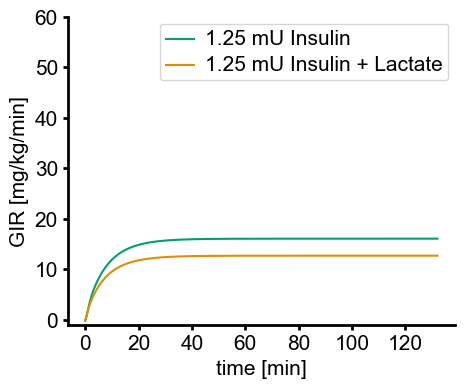

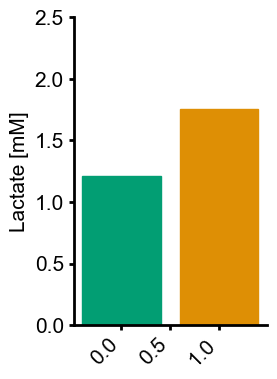

In [ ]:
# Dose dependence insulin 
from scipy.integrate import odeint
import seaborn as sns 


I0 = 0.034
# Figure 1 C/D  Insulin clamps
vI1 = 0.034/TAU_INS # Double basal fasted insulin levles
vI2 = 0.034*3/TAU_INS # Four times basal fasted insulin levles

# Lacatate infusion

vL = 0.4

# Glucose infusion rate over time
A = 1.0
euglycemic_clamp = lambda x,t,A,p,: equation(x,A,p) * np.array([1,0,1,1,1])
# VE 
scaling = 2000/6*180/1000 # 2000 nmol/min/g O2 , 6O2 / GLucose
GIR = lambda x,A,p: equation(x,A,p)[1] * scaling
# Time scaling 
t_scaling = 80*5.5/333


fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111)

# Intact glut4 
# Low insulin  clamp
y0 =[1,1,1,1,I0]
t = np.linspace(0,100,500)
ix=["v_in_I"]
p_ = [vI1] # equivalent to 3x fasted insulin
p = change_parameters(ref_parameters(), p_, ix=ix)

sol1 = odeint(euglycemic_clamp, y0, t, args=(A,p,))
plt.plot(t*t_scaling,[-GIR(x,A,p) for x in sol1], color=cb[2])

# Intralipid
ix=["v_in_I","v_in_L"]
p_ = [vI1,vL] # equivalent to 3x fasted insulin
p = change_parameters(ref_parameters(), p_, ix=ix)
y0 = steady_state(A,change_parameters(ref_parameters(),[vF], ix=['v_in_L']))
y0[1] = 1 

sol2 = odeint(euglycemic_clamp, y0, t, args=(A,p))
plt.plot(t*t_scaling,[-GIR(x,A,p) for x in sol2], color=cb[1])
 
# # Higher inuslin
# ix=["v_in_I",]
# p_ = [vI2,] # equivalent to 3x fasted insulin
# p = change_parameters(ref_parameters(), p_, ix=ix)
# y0 =[1,1,1,1,I0]
# sol3 = odeint(euglycemic_clamp, y0, t, args=(A,p))
# plt.plot(t*t_scaling,[-GIR(x,A,p) for x in sol3], color=cb[0])

# # Intralipid
# ix=["v_in_I","v_in_L"]
# p_ = [vI2,vK] # equivalent to 3x fasted insulin
# p = change_parameters(ref_parameters(), p_, ix=ix)
# y0 = steady_state(A,change_parameters(ref_parameters(),[vF], ix=['v_in_L']))
# y0[1] = 1 
# sol4 = odeint(euglycemic_clamp, y0, t, args=(A,p))
# ax.plot(t*t_scaling,[-GIR(x,A,p) for x in sol4], color=cb[3])

lables = ["1.25 mU Insulin","1.25 mU Insulin + Lactate",]
              #"2.5 mU Insulin","2.5 mU Insulin + Lactate",]
#plt.legend(lables, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.legend(lables,loc='upper right',)


# TODO scale this 
set_plot(ax,
         y_label='GIR [mg/kg/min]', 
         x_label='time [min]',
         y_ticks=np.linspace(0,60,7),
         x_ticks=np.linspace(0,120,7),
         font_size=font_size)


fig = plt.figure( figsize=(2.5,4))
ax = fig.add_subplot(111)

barlist = plt.bar([0,1],[sol1[-1,0]*0.7 , sol2[-1,0]*0.7,]) # sol3[-1,0]*0.5, sol4[-1,0]*0.5], )
#plt.plot([-0.5,3.5],[0.5, 0.5], '--', color='grey')
barlist[0].set_color(cb[2])
barlist[1].set_color(cb[1])
# barlist[2].set_color(cb[0])
# barlist[3].set_color(cb[3])

plt.xticks(rotation=45, ha='right')

# TODO scale this 
set_plot(ax,
         y_label='Lactate [mM]', 
         y_lim = [0,2.5],
         #y_ticks=np.linspace(0,0.5,3),
         #x_ticks=np.linspace(0,25,6),
         font_size=font_size)

In [ ]:
2000/6 * 0.4


133.33333333333334

In [ ]:
# Local sensitivity analysis for concentrations and Glucose infusion rate

def sensitivity_concentrations(parameter, parameter_names=parameter_names, delta=2.0):
    p0 = ref_parameters()
    this_value = p0[parameter_names.index(parameter)]
    p_down = change_parameters(p0, [this_value/delta,], ix=[parameter,])
    p_up = change_parameters(p0, [this_value*delta,], ix=[parameter,])
    X_0 = steady_state(1.0,p0)
    X_up = steady_state(1.0,p_up)
    X_down = steady_state(1.0,p_down)

    return (np.log2(X_up/X_0) / np.log2(delta) + np.log2(X_down/X_0) / np.log2(1./delta)) /2.0

vI3 = 0.034*5/TAU_INS # 8 times basal fasted insulin levles
vI2 = 0.034*3/TAU_INS # 4 times basal fasted insulin levles
vI = 0.034*1/TAU_INS # 2 times basal fasted insulin levles


def sensitivity_GIR(parameter, parameter_names=parameter_names, delta=2.0, insulin_levels=[vI1, vI2,]):
    p0 = ref_parameters()
    this_value = p0[parameter_names.index(parameter)]
    p_down = this_value/delta
    p_up = this_value*delta
    
    sensitivities = []
    for vI in insulin_levels:
        sol0, GIR0 = insulin_clamp_dynamic(vI, [0,100], 1.0, )
        
        kwargs = {parameter: p_up,}
        sol_up, GIR_up = insulin_clamp_dynamic(vI, [0,100], 1.0, **kwargs)
        
        kwargs = {parameter: p_down,}
        sol_down, GIR_down = insulin_clamp_dynamic(vI, [0,100], 1.0, **kwargs)
        
        X_0 = GIR0[-1]
        X_up = GIR_up[-1]
        X_down = GIR_down[-1]
        
        sens = (np.log2(X_up/X_0) / np.log2(delta) + np.log2(X_down/X_0) / np.log2(1./delta)) /2.0
        
        sensitivities.append(sens)
    
    return np.array(sensitivities)

In [ ]:
# Simulate perturbative simulations
def concentrations_dynamic(time,**kwargs):    
       # Unpack parameters 
    if kwargs == {}:
        p = ref_parameters()
    else:
        (keys,values) = zip(*kwargs.items())
        p = change_parameters(ref_parameters(), values, ix=keys)
       
    # ODE functions
    rhs = lambda x,t,A,p,: equation(x,A,p)
    
    
    # Get steady state
    X0 = [1,1,1,1,I0]
    X = odeint(rhs, X0, time, args=(A,p,))
    return X 


Text(0.5, 0, 'Time [min] ')

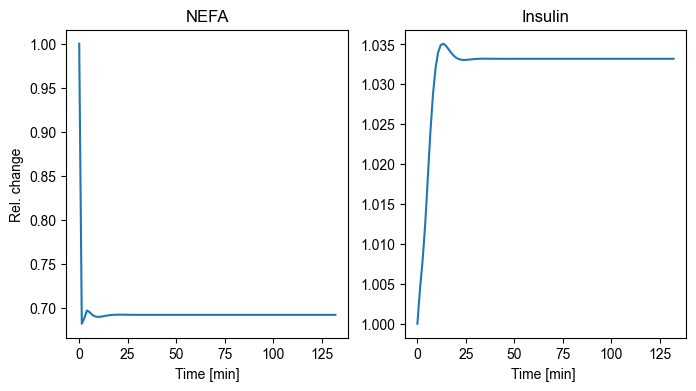

In [ ]:
# NOTE For won 
t = np.linspace(0,100,100)
X = concentrations_dynamic(t, v_in_L=0.4)

f, (ax1,ax2) = plt.subplots(1,2, figsize=(8,4))

#ax1.plot(t,X[:,0], 'k')
ax1.plot(t*t_scaling,X[:,2])
ax1.set_title("NEFA")

ax2.plot(t*t_scaling,X[:,4]/I0)
ax2.set_title("Insulin")

ax1.set_ylabel("Rel. change")
ax1.set_xlabel("Time [min]")
ax2.set_xlabel("Time [min] ")





In [ ]:
# Global sensitivity anlaysis 
from SALib.sample import sobol
from SALib.analyze import sobol

# Max changes = 2 fold 
p0 = ref_parameters()
fold_change = 

# Extended fold change 
ext_parameters = ['alpha',]
fold_change_ext = 10

# Parameters to vary 
parameters = ["vE","v0","omega", "lam", "gamma", "beta", "kappa", "alpha", "VR", "VFK", "VLG", "Imax",
              "KI_lipo", "KA_glut4", "KIL", "KIK", "KF", "KG", "KFK", "KL",]

p0_ =[ p0[parameter_names.index(p)] for p in parameters ]
# Define the model inputs
problem = {
    'num_vars': len(parameters),
    'names': parameters,
    'bounds': [(p/fold_change, p*fold_change_ext) if parameters[i] in ext_parameters
               else (p/fold_change, p*fold_change) for i,p in enumerate(p0_)]
}

# Generate samples
param_values = saltelli.sample(problem, 1024)

def evaluate(param_values, parameters=parameters, p0=p0):
    p = change_parameters(p0, param_values, ix=parameters)
    return steady_state(1,p)

Y = np.stack([evaluate(p) for p in param_values])

SyntaxError: invalid syntax (2677897067.py, line 7)

In [ ]:
Si_G = sobol.analyze(problem, Y[:,1], print_to_console=False);
Si_I = sobol.analyze(problem, Y[:,4], print_to_console=False);

NameError: name 'parameters' is not defined

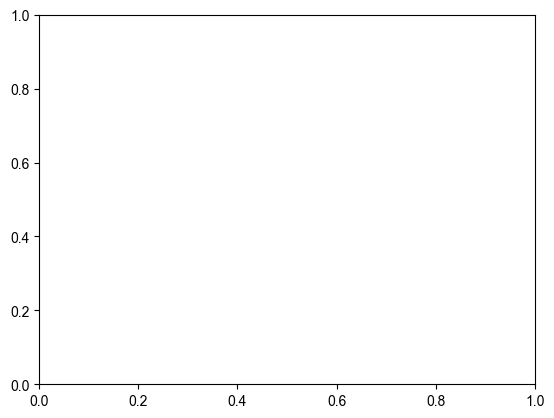

In [ ]:
fig, ax = plt.subplots(1,1)

plt.bar(parameters, Si_G['S1'])
plt.errorbar(range(len(parameters)), Si_G['S1'], xerr=Si_G['S1_conf'], linestyle='none', color='black')

plt.xticks(rotation=90,)

fig, ax = plt.subplots(1,1)

plt.bar(parameters, Si_I['S1'])
plt.errorbar(range(len(parameters)), Si_I['S1'], xerr=Si_I['S1_conf'], linestyle='none', color='black')

plt.xticks(rotation=90,)

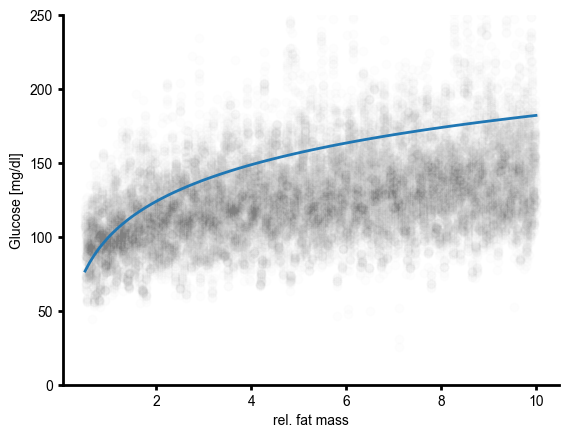

In [ ]:
fig, ax = plt.subplots(1,1)

ix = 1
ref_p = p0[parameter_names.index(parameters[7])]
ax.scatter(param_values[::2,7]/ref_p,Y[::2,ix] * 100, alpha=0.01, color='grey' )
# plot 
adipose = np.linspace(0.5,10,100)
G = np.array([steady_state(a,p0)[2] for a in adipose])
plt.plot(adipose, G * 100, linewidth=2, )

set_plot(ax, 
         y_lim = [0,250],
         x_label = "rel. fat mass",
         y_label = "Glucose [mg/dl]"
        )


In [ ]:
total_Si, first_Si, second_Si = Si_G.to_df()

In [ ]:
second_Si.

,S2,S2_conf
"(vE, v0)",-0.029477,0.056963
"(vE, omega)",-0.047074,0.059778
"(vE, lam)",-0.026985,0.055534
"(vE, gamma)",-0.033295,0.055293
"(vE, beta)",-0.036221,0.055603
...,...,...
"(KF, KFK)",-0.002174,0.016262
"(KF, KL)",-0.000027,0.016628
"(KG, KFK)",-0.004452,0.022509
"(KG, KL)",-0.008200,0.020639


array([2.00718065, 1.72474197, 3.36086924, ..., 0.63838815, 0.61115386,
       0.6754262 ])

In [ ]:
param_values

array([[-3.13238877, -0.77619428, -0.32827189],
       [-0.08283496, -0.77619428, -0.32827189],
       [-3.13238877,  0.3589515 , -0.32827189],
       ...,
       [-0.93572828,  0.80073797,  0.99095159],
       [-0.93572828,  0.81914574,  2.70901007],
       [-0.93572828,  0.81914574,  0.99095159]])

In [ ]:
#  ["vE", "k", "C", "KI_lipo", "KA_glut4", "KI_GY", "KIL", "KIK", "KF", "KG","omega", 
#   "lam", "gamma", "beta", "kappa", "alpha", "VR", "VFK", "KFK", "VLG", "KL",
#   "v0", "rho", "v_in_I", "v_in_L", "v_in_G", "v_in_F", "v_in_K", 
#   "with_LI", "with_SI", "with_GI", "with_LL", "with_LK"]

parameter_descirptions = {"vE": "Energy expenditure",
                          "k": "Insulin hill coeffcient",
                          "Imax": "Maximal insulin secrection capacity",
                          "C": "Insulin sec. threshold", 
                          "KI_lipo": "Insulin inhibition of lipolysis",
                          "KA_glut4": "Insulin activation of glucose uptake", 
                          "KI_GY": "Inusulin inhibition of Glycogen breakdown",
                          "KIL": "Lactate inhibition of lipolysis",
                          "KIK": "3HB inhibition of lipolysis",
                          "KF": "NEFA $K_M$ for resterification", 
                          "KG": "Glucose $K_M$ for resterification",
                          "omega": "Glycolytic propensity", 
                          "lam": "Lactate oxidation propensity", 
                          "gamma": "Glucose oxidation propensity", 
                          "beta": "NEFA oxidation propensity", 
                          "kappa": "3HB oxidation propensity", 
                          "alpha": "Lipolytic propensity",
                          "VR": "Reseterifcation $V_{max}$",  
                          "VFK": "Ketongenesis $V_{max}$",
                          "KFK":"NEFA $K_M$ for ketongenesis" ,
                          "VLG": "Gluconeogenesis $V_{max}$", 
                          "KL":"Lactate $K_M$ for gluconeogenesis",
                          "v0": "Glycogen breakdown flux",
                          "rho": "Fraction of regulated lipolysis",
                          "v_in_I": "Insulin infusion flux",
                          "v_in_L": "Lacate infsuion flux", 
                          "v_in_G": "Glucose infsuion flux", 
                          "v_in_F": "NEFA infsuion flux", 
                          "v_in_K": "3HB infsuion flux", 
                          "with_LI": "K/O of insulin inhibition lipolysis",
                          "with_SI": "K/O of insulin activation glucose uptake",
                          "with_GI": "K/O of insulin inhibition glycogen breakdown",
                          "with_LL": "K/O of lactate inhibition lipolysis",
                          "with_LK": "K/O of ketone inhibition lipolysis",
}


In [ ]:
import pandas as pd 
#fig = plt.figure(figsize=(10,2))
#ax = fig.add_subplot(111)

parameters = ["vE","v0","omega", "lam", "gamma", "beta", "kappa", "alpha", "VR", "VFK", "VLG", "Imax", "C",
              "KI_lipo", "KA_glut4", "KIL", "KIK", "KF", "KG", "KFK", "KL",]

features = ['Lactate','Glucose','NEFA','3HB','Insulin',] #'GIR 1.25 U insulin','GIR 2.5U insulin',]

S_C = np.stack([ sensitivity_concentrations(p) for p in parameters])

df = pd.DataFrame(S_C.T,columns=[parameter_descirptions[p] for p in parameters],index=features)

# S_max = 1.0 #np.max(abs(S))
# plt.pcolor(S.T, cmap="coolwarm", vmin=-S_max, vmax=S_max)
# plt.yticks([0.5,1.5,2.5,3.5,4.5,],['Lactate','Glucose','NEFA','3HB','Insulin']);
# plt.xticks( np.arange(len(parameters))+0.5, [parameter_descirptions[p] for p in parameters], rotation=45,ha='right');


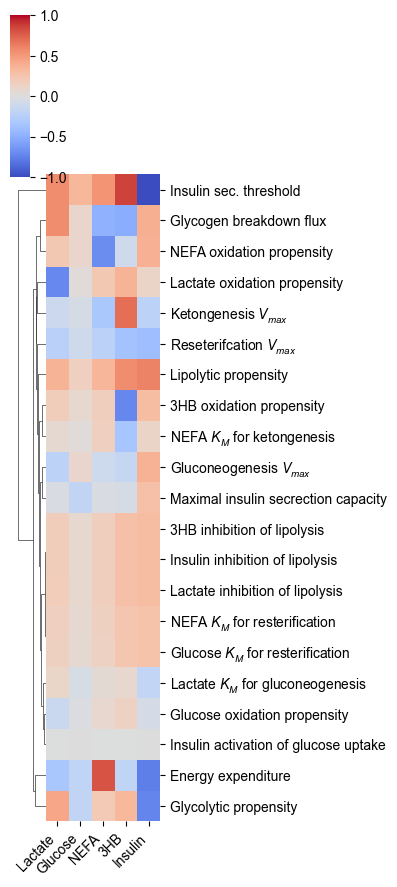

In [ ]:
# Plot clustermap
g = sns.clustermap(df.T,figsize=(4, 9) ,cmap="coolwarm", vmin=-1, vmax=1, col_cluster=False,)
plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), 
         rotation=45,ha='right'); 


c:\users\dw6835\src\insulin_models\venv\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


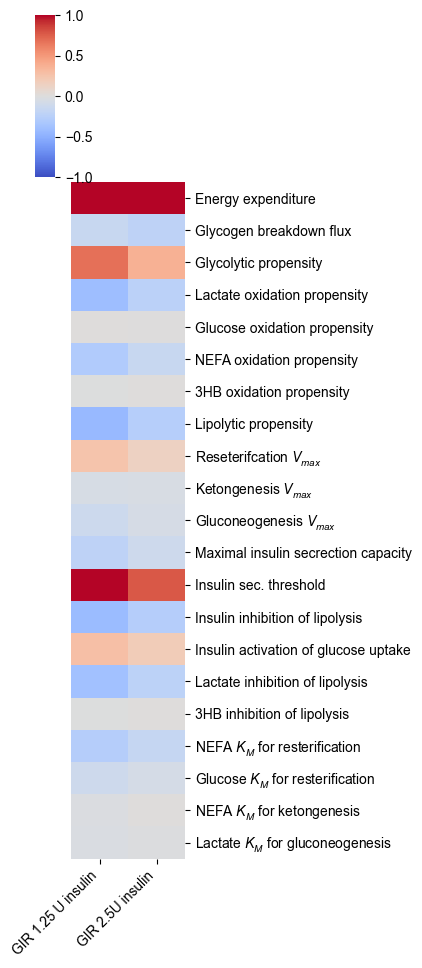

In [ ]:
S_max = 1.0#np.max(abs(S))

features = ['GIR 1.25 U insulin','GIR 2.5U insulin',]

S_C = np.stack([ sensitivity_GIR(p) for p in parameters])
df = pd.DataFrame(S_C.T,columns=[parameter_descirptions[p] for p in parameters],index=features)

g = sns.clustermap(df.T,figsize=(4, 9) ,cmap="coolwarm", vmin=-1, vmax=1, col_cluster=False, row_cluster=False)
plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), 
         rotation=45,ha='right'); 
